In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import kagglehub

path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Dataset path:", path)

Dataset path: /Users/srikarkodi/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [3]:
### Set Train/Test Paths ###
DATASET_DIR = path

TRAIN_DIR = os.path.join(DATASET_DIR, "seg_train", "seg_train")
TEST_DIR  = os.path.join(DATASET_DIR, "seg_test", "seg_test")

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR :", TEST_DIR)
print("Train folders:", os.listdir(TRAIN_DIR))
print("Test folders :", os.listdir(TEST_DIR))

TRAIN_DIR: /Users/srikarkodi/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train
TEST_DIR : /Users/srikarkodi/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test
Train folders: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']
Test folders : ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [4]:
### Create Dataset batches (Train/Test) ###
SEED = 42
IMG_SIZE = (150, 150)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Batch size:", BATCH_SIZE)

Found 14034 files belonging to 6 classes.


2026-02-13 14:06:39.812667: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-02-13 14:06:39.812883: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-13 14:06:39.812902: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-13 14:06:39.813269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-13 14:06:39.813298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Batch size: 16


2026-02-13 14:07:00.197483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


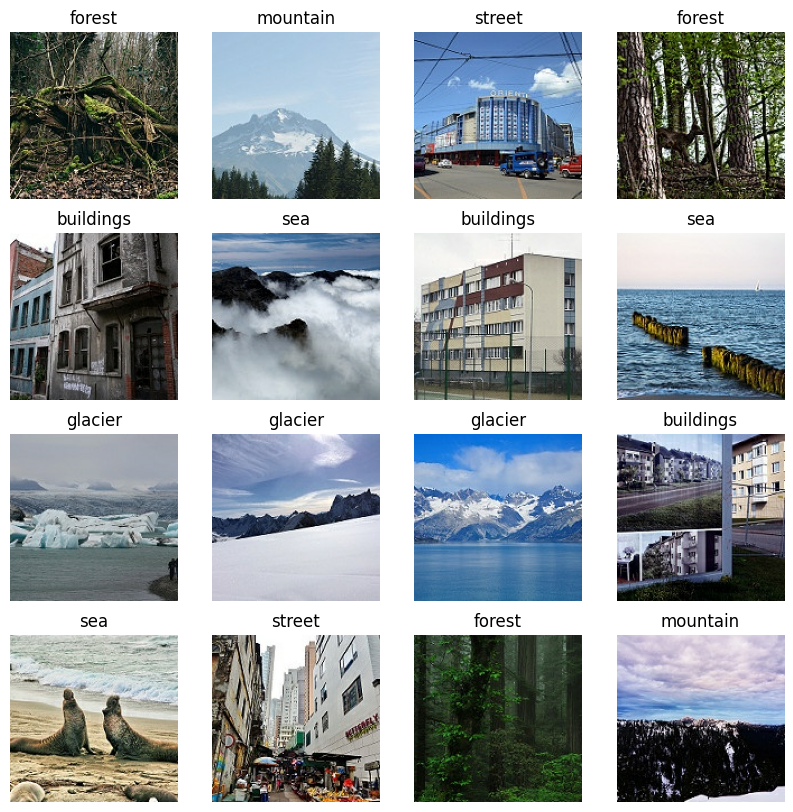

In [5]:
### Show Sample Images ###
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

plt.show()

In [6]:
### Prefetch ###
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

In [7]:
### Data Augmentation and Normalization ###
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

normalization = layers.Rescaling(1./255)

In [8]:
### Baseline CNN ###
cnn_model = keras.Sequential([
    layers.Input(shape=(150,150,3)),
    data_augmentation,
    normalization,

    layers.Conv2D(32,3,activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64,3,activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128,3,activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes,activation="softmax")
])

cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
### Train CNN ###
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

cnn_history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=12,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/12


2026-02-13 14:08:36.993803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


878/878 - 40s - 45ms/step - accuracy: 0.5313 - loss: 1.2357 - val_accuracy: 0.6687 - val_loss: 0.9246
Epoch 2/12
878/878 - 35s - 40ms/step - accuracy: 0.6072 - loss: 1.0796 - val_accuracy: 0.6800 - val_loss: 0.9438
Epoch 3/12
878/878 - 37s - 43ms/step - accuracy: 0.6423 - loss: 1.0200 - val_accuracy: 0.6973 - val_loss: 0.9174
Epoch 4/12
878/878 - 36s - 41ms/step - accuracy: 0.6690 - loss: 0.9752 - val_accuracy: 0.6853 - val_loss: 0.9812
Epoch 5/12
878/878 - 36s - 41ms/step - accuracy: 0.6916 - loss: 0.9244 - val_accuracy: 0.7267 - val_loss: 1.0131
Epoch 6/12
878/878 - 36s - 41ms/step - accuracy: 0.6835 - loss: 1.0557 - val_accuracy: 0.6997 - val_loss: 1.1289
Epoch 7/12
878/878 - 37s - 42ms/step - accuracy: 0.6910 - loss: 1.1574 - val_accuracy: 0.6913 - val_loss: 1.3440
Epoch 8/12
878/878 - 36s - 41ms/step - accuracy: 0.6911 - loss: 1.2212 - val_accuracy: 0.7460 - val_loss: 1.2734
Epoch 9/12
878/878 - 37s - 42ms/step - accuracy: 0.7088 - loss: 1.2456 - val_accuracy: 0.7500 - val_loss: 1

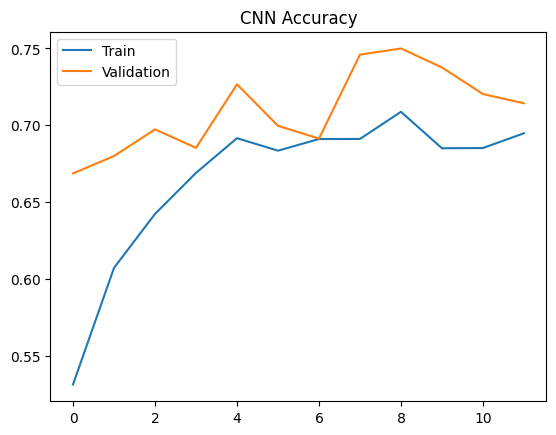

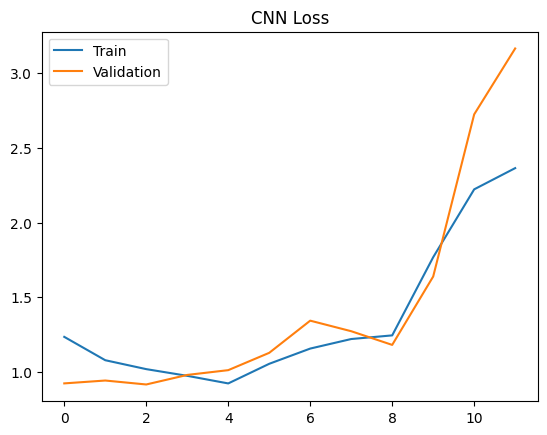

In [10]:
### CNN Plots ###
plt.plot(cnn_history.history["accuracy"])
plt.plot(cnn_history.history["val_accuracy"])
plt.title("CNN Accuracy")
plt.legend(["Train","Validation"])
plt.show()

plt.plot(cnn_history.history["loss"])
plt.plot(cnn_history.history["val_loss"])
plt.title("CNN Loss")
plt.legend(["Train","Validation"])
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7500 - loss: 1.1819
CNN Accuracy: 0.75
              precision    recall  f1-score   support

   buildings       0.82      0.60      0.69       437
      forest       0.95      0.88      0.91       474
     glacier       0.82      0.67      0.73       553
    mountain       0.91      0.52      0.66       525
         sea       0.60      0.89      0.71       510
      street       0.65      0.95      0.77       501

    accuracy                           0.75      3000
   macro avg       0.79      0.75      0.75      3000
weighted avg       0.79      0.75      0.75      3000



2026-02-13 14:17:21.761871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


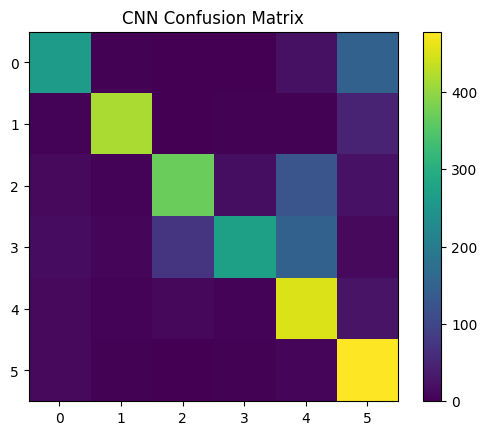

In [11]:
### CNN Evaluation ###
cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
print("CNN Accuracy:", cnn_acc)

y_true=[]
y_pred=[]

for imgs, labs in test_ds:
    p = cnn_model.predict(imgs,verbose=0)
    y_pred.extend(np.argmax(p,axis=1))
    y_true.extend(labs.numpy())

print(classification_report(y_true,y_pred,target_names=class_names))

cm = confusion_matrix(y_true,y_pred)
plt.imshow(cm)
plt.title("CNN Confusion Matrix")
plt.colorbar()
plt.show()

In [12]:
### ResNet50 Transfer Model ###
base_model = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(150,150,3)
)

base_model.trainable=False

inputs = keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)

resnet_model = keras.Model(inputs,outputs)

resnet_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 150, 150,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 150, 150)  │          0 │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 150, 150)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 150, 150)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 150, 150,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 150, 150,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │     12,294 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
### Train Resnet (Frozen) ###
resnet_history_1 = resnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/6
878/878 - 78s - 89ms/step - accuracy: 0.8645 - loss: 0.3867 - val_accuracy: 0.9067 - val_loss: 0.2560
Epoch 2/6
878/878 - 85s - 96ms/step - accuracy: 0.9000 - loss: 0.2970 - val_accuracy: 0.9190 - val_loss: 0.2442
Epoch 3/6
878/878 - 95s - 108ms/step - accuracy: 0.9007 - loss: 0.2943 - val_accuracy: 0.9133 - val_loss: 0.2659
Epoch 4/6
878/878 - 98s - 112ms/step - accuracy: 0.9044 - loss: 0.2761 - val_accuracy: 0.9207 - val_loss: 0.2512
Epoch 5/6
878/878 - 102s - 116ms/step - accuracy: 0.9051 - loss: 0.2778 - val_accuracy: 0.9147 - val_loss: 0.2692
Epoch 6/6
878/878 - 104s - 118ms/step - accuracy: 0.9060 - loss: 0.2808 - val_accuracy: 0.9110 - val_loss: 0.2819


In [14]:
### Fine Tuning ###
base_model.trainable=True

for layer in base_model.layers[:-30]:
    layer.trainable=False

resnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_history_2 = resnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    verbose=2
)

Epoch 1/6
878/878 - 149s - 169ms/step - accuracy: 0.8874 - loss: 0.3303 - val_accuracy: 0.9150 - val_loss: 0.2813
Epoch 2/6
878/878 - 163s - 186ms/step - accuracy: 0.9101 - loss: 0.2568 - val_accuracy: 0.9213 - val_loss: 0.2589
Epoch 3/6
878/878 - 165s - 187ms/step - accuracy: 0.9213 - loss: 0.2152 - val_accuracy: 0.9237 - val_loss: 0.2476
Epoch 4/6
878/878 - 148s - 169ms/step - accuracy: 0.9319 - loss: 0.1926 - val_accuracy: 0.9277 - val_loss: 0.2343
Epoch 5/6
878/878 - 142s - 162ms/step - accuracy: 0.9374 - loss: 0.1667 - val_accuracy: 0.9320 - val_loss: 0.2325
Epoch 6/6
878/878 - 147s - 167ms/step - accuracy: 0.9484 - loss: 0.1417 - val_accuracy: 0.9317 - val_loss: 0.2292


188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9317 - loss: 0.2292
ResNet Accuracy: 0.9316666722297668
              precision    recall  f1-score   support

   buildings       0.93      0.94      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.91      0.86      0.88       553
    mountain       0.90      0.88      0.89       525
         sea       0.93      0.98      0.96       510
      street       0.94      0.94      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



2026-02-13 14:45:17.983186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


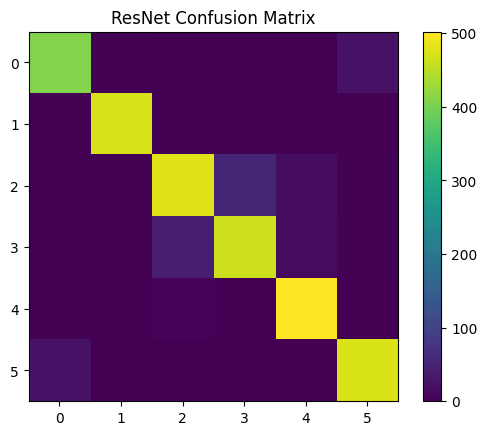

In [15]:
### ResNet Evaluation ###
res_loss,res_acc = resnet_model.evaluate(test_ds)
print("ResNet Accuracy:",res_acc)

y_true=[]
y_pred=[]

for imgs,labs in test_ds:
    p=resnet_model.predict(imgs,verbose=0)
    y_pred.extend(np.argmax(p,axis=1))
    y_true.extend(labs.numpy())

print(classification_report(y_true,y_pred,target_names=class_names))

cm=confusion_matrix(y_true,y_pred)
plt.imshow(cm)
plt.title("ResNet Confusion Matrix")
plt.colorbar()
plt.show()